In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

In [3]:
file = './HadISST_sst.nc'
dataset = nc.Dataset(file)
# print(dataset.variables.keys())

longitude, latitude = dataset.variables['longitude'],dataset.variables['latitude']
time = dataset.variables['time']
sst =dataset.variables['sst']

cor_num = pd.read_excel(io = r'./ACE.xlsx')
coordinate = cor_num['WP-NA'].tolist()

In [4]:
num_month = time[:].data.shape[0] # 创建空时间矩阵
num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
num_month_2021to1998 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数
sum_month = np.zeros(sst[:1].data[0][44:136,:].shape, dtype=float, order='C') # 创建空矩阵

# sum_month_year = sum_month

ls_mean_year = []
for i in range(1343, 1343+num_month_1997to1982+num_month_2021to1998, 12): 
    sum_month_year =  np.zeros(sst[:1].data[0][44:136,:].shape, dtype=float, order='C')
    for month in range(12):
        tmp_month = i + month
        tmp_pre = sst[tmp_month:tmp_month+1].data[0][44:136,:]
        sum_month_year += tmp_pre
    mean_year = sum_month_year / 12
#     mean_year = mean_year.tolist()
    ls_mean_year.append(mean_year)

ls_mean_year = np.array(ls_mean_year)
reshape_mean = ls_mean_year.transpose(1,2,0)


In [140]:
ls_mean_year.shape

(40, 92, 360)

In [141]:
reshape_mean.shape

(92, 360, 40)

In [5]:
from scipy.stats import pearsonr

pearson_matrix = np.zeros((92,360), dtype=float, order='C')
p_value = np.zeros((92,360), dtype=float, order='C')

for i in range(len(reshape_mean)):
    for j in range(len(reshape_mean[i])):
        x = reshape_mean[i][j]
        y = coordinate
        tmp_correlation, _ = pearsonr(x, y)
#         print(tmp_correlation)
        pearson_matrix[i][j] = tmp_correlation
        p_value[i][j] = _
pearson_matrix = np.nan_to_num(pearson_matrix)

/home/lk/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [123]:
pearson_matrix.shape

(92, 360)

In [91]:
pearsonr(coordinate, reshape_mean[:1,:1,:][0][0])

(-0.3196173242805709, 0.04438721651191724)

In [131]:
lon = longitude[:].data
lat = latitude[44:136].data

print(len(lon), len(lat), pearson_matrix.shape)
print(pearson_matrix.max(), pearson_matrix.min())

360 92 (92, 360)
0.6035904289591274 -0.7307910759379668


In [6]:
# 时间 1982年到1997年12月共计 16年 总共192个月
# time[:].data[1343:1535] % 365
# 时间  1998年到2021年 共计24年总共288个月
# time[:].data[1535:1823] % 365

sum_month = np.zeros(sst[:1].data.shape, dtype=float, order='C') # 创建空矩阵
num_month = time[:].data.shape[0] # 创建空时间矩阵
num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
num_month_2021to1998 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数

sum_month = np.zeros(sst[:1].data[0][44:136,:].shape, dtype=float, order='C') # 创建空矩阵
sum_month_1982to1997 = sum_month
count1 = 0
ls_first = []
mean_1982to1997 = sum_month
for i in range(1343, 1343+num_month_1997to1982): 
    temp_pre = sst[i:i+1].data[0][44:136,:]
#     ls_first.append(sst[i:i+1].data[0][:1,-1:])
    sum_month_1982to1997 += temp_pre
    count1 += 1
mean_1982to1997 = sum_month_1982to1997 / num_month_1997to1982

sum_month = np.zeros(sst[:1].data[0][44:136,:].shape, dtype=float, order='C') # 创建空矩阵
sum_month_1998to2021 = sum_month
count2 = 0
ls_first = []
mean_1998to2021 = sum_month
for i in range(1534, 1534+num_month_2021to1998): 
    temp_pre = sst[i:i+1].data[0][44:136,:]
#     ls_first.append(sst[i:i+1].data[0][:1,-1:])
    sum_month_1998to2021 += temp_pre
    count2 += 1
mean_1998to2021 = sum_month_1998to2021 / num_month_2021to1998

diff = mean_1998to2021 - mean_1982to1997

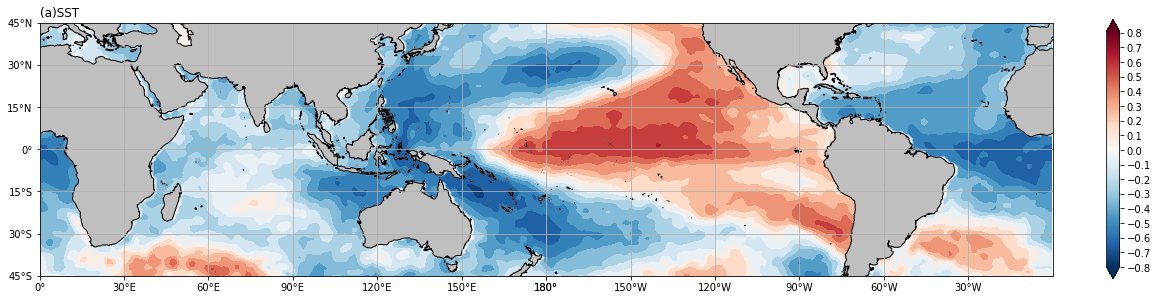

In [7]:
lon = longitude[:].data
lat = latitude[44:136].data

data = pearson_matrix 

# 调整经纬度 向东偏移180
lon_pacific = lon[:] + 180
a, b = np.hsplit(data, [179])
data = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据

fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (-180, 181, -45,45)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a)SST',loc='left',fontsize =12)
 
cont = fig_ax1.contourf(lon_pacific, lat, data, 
                 levels=np.arange(-0.80, 0.81, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

norm = colors.Normalize(vmin=-0.80, vmax=0.81)    #确定colormap的最大最小值



fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
                 orientation='vertical',
                 ticks=np.arange(-0.80, 0.81, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 


plt.savefig("sst_correl.png",dpi=300,bbox_inches='tight')
plt.show()

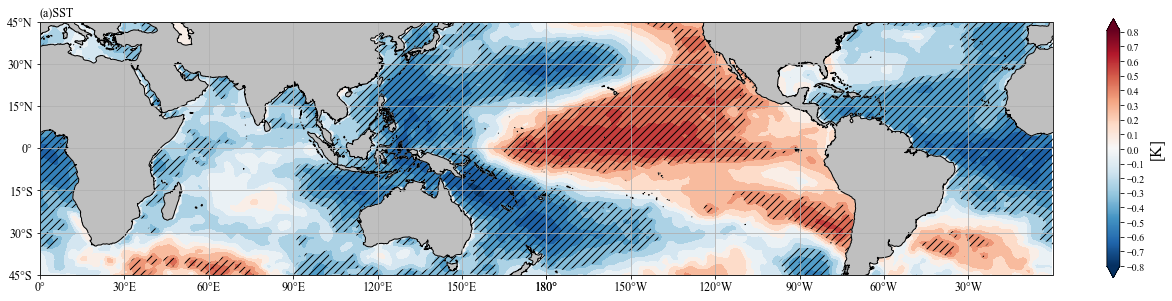

In [11]:
# 相关关系显著性打点
from matplotlib.font_manager import FontProperties

plt.rc('font',family='Times New Roman') 
lon = longitude[:].data
lat = latitude[44:136].data

data = pearson_matrix 

# 调整经纬度 向东偏移180
lon_pacific = lon[:] + 180
a, b = np.hsplit(data, [179])
data = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据

fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (-180, 181, -45,45)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.contourf(lon, lat, p_value,
            [np.nanmin(p_value), 0.05, np.nanmax(p_value)],
#                  [0.01, 0.05, np.nanmax(p_value)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())

labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a)SST',loc='left',fontsize =12)
 
cont = fig_ax1.contourf(lon_pacific, lat, data, 
                 levels=np.arange(-0.80, 0.81, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

norm = colors.Normalize(vmin=-0.80, vmax=0.81)    #确定colormap的最大最小值

# fig_ax1.contourf(lon, lat, p_value,
#             [np.nanmin(p_value), 0.05, np.nanmax(p_value)],
# #                  [0.01, 0.05, np.nanmax(p_value)],
#             hatches=['.', None], colors="none",
#             transform = ccrs.PlateCarree())

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
                 orientation='vertical',
                 ticks=np.arange(-0.80, 0.81, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }
fc1.set_label(label="[K]", fontdict=font) #设置colorbar的标签字体及其大小


plt.savefig("sst_correl.png",dpi=300,bbox_inches='tight')
plt.show()

1.4641342692905006 -0.6092177894380377


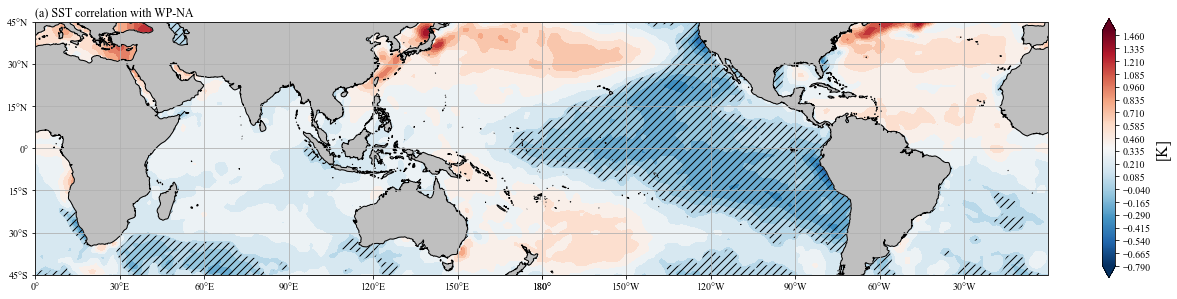

In [10]:
# 用p_value的显著性打点
lon = longitude[:].data
lat = latitude[44:136].data
# 调整经纬度 向东偏移180
lon_pacific = lon[:] + 180
a, b = np.hsplit(diff, [179])
diff_pacific_contre = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据
print(diff_pacific_contre.max(), diff_pacific_contre.min())
# data = pearson_matrix 

# 调整经纬度 向东偏移180
lon_pacific = lon[:] + 180
a, b = np.hsplit(data, [179])
data = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据

fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (-180, 181, -45,45)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.contourf(lon_pacific, lat, diff_pacific_contre,
            [np.nanmin(diff_pacific_contre), 0.05, np.nanmax(diff_pacific_contre)],
#                  [0.01, 0.05, np.nanmax(p_value)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) SST correlation with WP-NA',loc='left',fontsize =12)
 
cont = fig_ax1.contourf(lon_pacific, lat, diff_pacific_contre, 
                 levels=np.arange(-0.79,1.51,0.125),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

norm = colors.Normalize(vmin=-0.79, vmax=1.51)    #确定colormap的最大最小值

# fig_ax1.contourf(lon, lat, p_value,
#             [np.nanmin(p_value), 0.05, np.nanmax(p_value)],
# #                  [0.01, 0.05, np.nanmax(p_value)],
#             hatches=['.', None], colors="none",
#             transform = ccrs.PlateCarree())

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
                 orientation='vertical',
                 ticks=np.arange(-0.79,1.51,0.125).tolist(),                                                    
                 extend='both',
                fraction=0.012) 

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }
fc1.set_label(label="[K]", fontdict=font) #设置colorbar的标签字体及其大小
plt.savefig("sst_point.png",dpi=300,bbox_inches='tight')
plt.show()